<a href="https://colab.research.google.com/github/eljimenezj/CM0868--Estadistica-Multivariada-Avanzada/blob/master/Modelacion_Final_Proyecto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estadistica Multivariada - Clasificación de imagenes utilizando Machine Learning y Deep Learning

A continuación se presenta un estudio de clasificación de imagenes utilizando un modelo de regresión logística y posteriormente el uso de redes neuronales profundas. Esto libro hace parte del proyecto final del curso de Estadistica Multivariada Avanzanda de la Maestría de Ciencia de Datos.

Los integrantes de este trabajo:

* Jorge Luis Renteria Roa - jlrenteria@eafit.edu.co
* Edgar Leandro Jimenez Jaimes - eljimenezj@eafit.edu.co

Profesor: Tomas Olarte

Este libro se encuentra organizado de la siguiente manera:

1. Lectura y estructuración del pipeline de los datos.
  * Estructuración del Data Augmentation utilizando `ImageDataGenerator`
2. Construcción y entrenamiento modelo de regresión logistica.
3. Construcción y entrenamiento Red Neuronal Convolucional construida desde cero.
4. Entrenamiento de red neuronal preentrenada:
  * `ResNet50`




# Introducción

Los negocios del sector gastronómico son similares en que la gran mayoría de ellos llevan sus procesos de manera convencional con una participación casi nula de los datos para la toma de decisiones, por ello, preguntas como ¿Cuánto productos X hemos elaborado? suelen responderse con base a la sensación de los empleados. Utilizar métodos de visión computacional y algoritmos de aprendizaje a través de redes neuronales representan una alternativa como respuesta tecnológica de esas preguntas.

Con el desarrollo de esta investigación se pretende evaluar la factibilidad de implementar modelos robustos para clasificar de manera precisa dos clases (dos tipos de pizza) en un conjunto de imágenes. Todo esto apalancado en los conceptos recibidos en clase y con la motivación personal extra de disrumpir la manera tradicional de controlar los negocios a través de métodos inteligentes de bajo costo al alcance de pequeños emprendedores (quienes son los más afectados por el problema) y escalable a los de mayor tamaño.


In [0]:
# Vamos a cargar las Librerias necesarias para preprocesar
from PIL import Image
import pandas as pd
import glob
import re
import numpy as np
import imutils
import time
import os  
import seaborn as sn  
import datetime
from tqdm import tqdm
from pathlib import Path

import tensorflow as tf
import keras_preprocessing
from keras.applications import densenet  
from keras import regularizers  
from keras import backend as K  
from keras.preprocessing import image
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential  
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.models import Sequential, Model, load_model  
from keras.layers import Activation, Dropout, Flatten, Dense  
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback  
  
from google.colab import drive
from google.colab import files
import matplotlib.pyplot as plt


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, classification_report  

from keras.backend import manual_variable_initialization 
manual_variable_initialization(True)

import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 30*30 + 1)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# 1. Lectura y estructuración del pipeline de los datos.

## 1.1 Estructuración del Data Augmentation utilizando ImageDataGenerator

In [0]:
'''
# Ahora realizamos la autenticacion necesaria para Google Drive
# e ir a buscar los datos almacenados, esto debe realizare cada vez
# que se reinicie el Colab 
'''

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
'''
# Definición de algunos parametros de entrada que serviran de control durante el notebook. Las variables
# img_width, img_height configuran el ancho y alto en pixeles que se van a tomar de las imagenes de entradas
# nb_train_samples se refiere al Numero inicial de muestras en train, nb_validation_samples y nb_test_samples
# al numero de imagenes en validacion y test respectivamente. Y el batch_size será el encargado de controlar
# un numero de imagenes dado, es decir el valor configurado se refiere a un numero de imagenes
'''

img_width, img_height = 400, 400  
nb_train_samples = 50             
nb_validation_samples = 16        
nb_test_samples = 17
batch_size = 8                    

'''
# Hacemos definición de los directorios donde se encuentra la información, estas imagenes se encuentran
# almacenadas por carpetas y divididas en las clase 1 y 2 respectivamente
'''

path_base = '/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales'
train_data_dir = path_base + '/Train'  
validation_data_dir = path_base + '/Validation'
test_data_dir = path_base + '/Test'


A continuación se van a configurar los generadores de datos que nos van a servir para establecer los datos de entrenamiento, de validación y de testeo. Para esta tarea se utiliza `ImageDataGenerator`  la cual  una función creada en Keras que genera pilas de imágenes con datos crecientes en tiempo real. Los códigos más básicos para crear y configurar el data augmentation y para formar una red neural profunda con imágenes mejoradas son los siguientes

In [0]:
''''
Estructuramos el DataAugmentacion que se va a utilizar durante el entrenamiento de las imagenes para esto se utiliza 
ImageDataGenerator como se menciono anteriormente, la cual se configuro de la siguiente manera:

--> rescale: Se utiliza para hacer una normalizacion de los datos de entrada, para esto se utilizo la forma que 
realiza el preprocesamiento de datos de resnet50: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
este rescale se utilizara tanto para los datos de train, como de validacion y test de todos los modelos.

--> horizontal_flip:  Ejecuta vueltas a las imagenes (efecto similar a un espejo)

--> rotation_range: Rotaciónn de la imagen en el rango [0,90]

--> brightness_range: Cambia los niveles de luminosidad de la imagen

--> : Realiza Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)

# Importacion
imgen = ImageDataGenerator(rescale=1/255)
''''

# Generador Data Augmentacion en Train 
train_datagen = ImageDataGenerator(  
    rescale=1. / 127.5 - 1,                                                                     
    horizontal_flip=True,                                         
    rotation_range=90,                                            
    brightness_range=[0.2,0.8],                                   
    zoom_range=[0.8,1.2])        
                                 
'''
Ahora instanciamos lo que se utilizará como datos de entranmiento y le damos el directorio donde se encuentran
las imagenes, teniendo en cuenta el train.datagen anterior que será el encargado de realizar el data augmentation
'''

train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                               # Directorio de datos de entrenamiento  
    target_size=(img_width, img_height),                          # Dimensiones de las imagenes    
    batch_size=batch_size,                                        # Particiones por imagenes                        
    class_mode='binary')                                          # Tipo de clase de labels


'''
Ahora instanciamos lo que se utilizará como datos de validación y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''

validation_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 
validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary') 

'''
Ahora instanciamos lo que se utilizará como datos de test y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''

test_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary') 


Found 50 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [0]:
'''
Con estas lineas de codigo a continuación revisamos cuantas imagenes tenemos en las carpetas de los 
directorios y a que clase pertenecen.
'''
import os
clase1_train = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales/Train/Clase1')])
clase2_train = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales/Train/Clase2')])

clase1_validation = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales/Validation/Clase1')])
clase2_validation = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales/Validation/Clase2')])

clase1_test = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales/Test/Clase1')])
clase2_test = sum([len(files) for r, d, files in os.walk('/content/drive/My Drive/Estadistica Multivariada/Proyecto Final/Dataset/imagenes_finales/Test/Clase2')])


print('Numero de registros para clase 1 en train es', clase1_train)
print('Numero de registros para clase 1 en train es', clase2_train)
print('----------------------------------------------------------')
print('Numero de registros para clase 1 en validation es', clase1_validation)
print('Numero de registros para clase 1 en validation es', clase2_validation)
print('----------------------------------------------------------')
print('Numero de registros para clase 1 en test es', clase1_test)
print('Numero de registros para clase 1 en test es', clase2_test)
print('----------------------------------------------------------')

Numero de registros para clase 1 en train es 34
Numero de registros para clase 1 en train es 17
----------------------------------------------------------
Numero de registros para clase 1 en validation es 11
Numero de registros para clase 1 en validation es 5
----------------------------------------------------------
Numero de registros para clase 1 en test es 12
Numero de registros para clase 1 en test es 5
----------------------------------------------------------


A continuación se presenta la construcción y ejecución de los modelos. Para cada modelo de ML, que se presenta a continuacion, se realiza en primer lugar la instanciación del modelo mediante `Keras`, posteriormente se compila y por último se ejecuta por un númnero de epocas predefinido por el usuario .

Los modelos de clasificacion que se tuvieron en cuenta para esta modelacion son los siguientes:


* Regresión logistica utilizando `Keras`
* Red neuronal convolucional con arquitectura propuesta  utilizando `Keras`
* Red neuronal preentrenada - Resnet50 - utilizando `Keras` 

# Construcción y ejecución de modelos de Deep Learning 

## 1. Modelo de regresión logística con Keras - TensorFlow

A continuación vamos a construir una regresión logistica como un primer modelo, pero utilizando Keras de TensorFlow. Esto es una red neuronal de una neurona con una función de activación sigmoide:

$$f(x)=\frac{1}{1+e^{-x}}$$

In [0]:

'''
A continuación realizamos la construcción de la  regresión logistica, este modelo se realizara con Keras
utilizando una sola neurona de salida la cual tendra la función sigmoide. Para cada creacion y entrenamiento de los modelos
utilizamos K.clear_session() para limpiar la sesion de registros guardados anteriormente 
'''
K.clear_session()
model_1 = Sequential()
model_1.add(Flatten(input_shape=(400,400,3)))      # Entrada de las imagenes, formato y profundidad  
model_1.add(Dense(1))                              # Agregar una neurona  
model_1.add(Activation('sigmoid'))                 # Función de activación sigmoide    

model_1.summary()                                  # Mirar arquitectura del modelo

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 480000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 480001    
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 480,001
Trainable params: 480,001
Non-trainable params: 0
_________________________________________________________________


Podemos observar el resumen de la arquitectura del modelo, donde los datos de entradas son los pixeles de las imagenes y estas pasara por una función de activacion que es precisamente la función logistica.

In [0]:
'''
Una vez construida construida la arquitectura de la red, o en este caso de la regresion logistica
debemos compilar el modelo, en este paso definimos que función de perdida vamos a utilizar, que optimizador 
y que metricas queremos medir. Para esta modelación se utilizói lo siguiente

--> Función de perdida (loss): binary_crossentropy: La función de pérdida de crossentropía binaria se usa en decisiones sí / no, 1 / 0, por ejemplo.
La pérdida le dice cuán equivocadas son las predicciones del modelo: https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy

--> Optimizador: Adam con tasa de aprendizaje 0.0001: Adam es un método de descenso de gradiente estocástico que se basa en la estimación adaptativa de 
los momentos de primer y segundo orden: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

--> Metrica: AUC: (Área bajo la curva) el cual mide  el “área o espacio” bajo la curva ROC y tiene por objeto medir la certeza de un modelo a la 
hora de realizar predicciones (toma valor de 1 cuándo se es 100% preciso) siendo invariable al umbral de clasificación.
https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
'''
 
model_1.compile(loss='binary_crossentropy',                                        
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),                
              metrics=[tf.keras.metrics.AUC()])                                                   
                         

'''
Una vez tenemos lista la arquitectura y compilado el modelo procedemos a realiza el entrenamiento mediante el metodo fit_generator
en donde se le define cuales son los datos de entrada, el numero de epocas (# numero de veces que la red pasa por los datos) y cuales
son los datos de validacion
'''
historia1 = model_1.fit_generator(train_generator,                                   
                    epochs=80,                                                       
                    validation_data=validation_generator)                             


Epoch 1/80
7/7 [==============================] - 3s 492ms/step - loss: 846.7967 - auc: 0.5225 - val_loss: 3342.3723 - val_auc: 0.5442
Epoch 2/80
7/7 [==============================] - 3s 445ms/step - loss: 1618.7660 - auc: 0.5386 - val_loss: 485.4955 - val_auc: 0.5220
Epoch 3/80
7/7 [==============================] - 3s 440ms/step - loss: 926.5575 - auc: 0.5081 - val_loss: 541.5670 - val_auc: 0.5176
Epoch 4/80
7/7 [==============================] - 3s 444ms/step - loss: 254.3201 - auc: 0.5034 - val_loss: 509.8358 - val_auc: 0.4975
Epoch 5/80
7/7 [==============================] - 3s 446ms/step - loss: 126.2615 - auc: 0.4998 - val_loss: 577.6507 - val_auc: 0.5044
Epoch 6/80
7/7 [==============================] - 3s 446ms/step - loss: 124.1154 - auc: 0.5100 - val_loss: 471.0528 - val_auc: 0.5181
Epoch 7/80
7/7 [==============================] - 3s 451ms/step - loss: 180.8175 - auc: 0.5152 - val_loss: 454.3970 - val_auc: 0.5145
Epoch 8/80
7/7 [==============================] - 3s 445ms/s

In [0]:
'''
Evaluamos el modelo con los datos de testeo una vez tenemos listo las correcciones necesarias y las validaciones
'''
model_1.evaluate_generator(test_generator)

[2.8899337783938606e-11, 0.5911798477172852]

In [0]:
'''
Guardo el modelo con este metodo en caso de que sea necesario
'''
model_1.save("modelo_regresion.h5")

### Graficas de desempeño

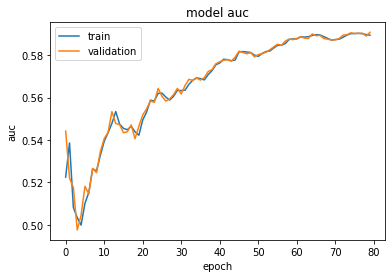

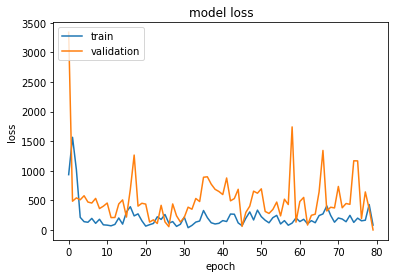

In [0]:
'''
Para evaluar como ha sido el desempeño del modelo realizamos un par de graficos
que nos muestran como se comporto la metrica AUC, tanto del conjunto de entrenamiento
como de validacion, durante las epocas en que se entreno el modelo.

Como segunda grafica observamos el comportamiento de la funcion de costo, al igual que el 
auc, para train y validacion durante todas las epocas
'''
# Grafica 1: Comportamiento desempeño AUC 
plt.plot(historia1.history['auc'])
plt.plot(historia1.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Grafica 2: Comportamiento funcion de perdida
plt.plot(historia1.history['loss'])
plt.plot(historia1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 2. Red Neuronal Convolucional creada

In [0]:
''''
Estructuramos el DataAugmentacion que se va a utilizar durante el entrenamiento de las imagenes para esto se utiliza 
ImageDataGenerator como se menciono anteriormente, la cual se configuro de la siguiente manera:

--> rescale: Se utiliza para hacer una normalizacion de los datos de entrada, para esto se utilizo la forma que 
realiza el preprocesamiento de datos de resnet50: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
este rescale se utilizara tanto para los datos de train, como de validacion y test de todos los modelos.

--> horizontal_flip:  Ejecuta vueltas a las imagenes (efecto similar a un espejo)

--> rotation_range: Rotaciónn de la imagen en el rango [0,90]

--> brightness_range: Cambia los niveles de luminosidad de la imagen

--> : Realiza Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)
''''

train_datagen = ImageDataGenerator(
    rescale=1. / 127.5 - 1,                                      
    horizontal_flip=True,                                        
    rotation_range=90,                                           
    brightness_range=[0.2,0.8],                                  
    zoom_range=[0.8,1.2])                                       

'''
Ahora instanciamos lo que se utilizará como datos de entranmiento y le damos el directorio donde se encuentran
las imagenes, teniendo en cuenta el train.datagen anterior que será el encargado de realizar el data augmentation
'''
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                              
    target_size=(img_width, img_height),                            
    batch_size=batch_size,                                                          
    class_mode='binary')                                         


'''
Ahora instanciamos lo que se utilizará como datos de validación y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''

validation_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 
validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, 
    class_mode='binary') 

'''
Ahora instanciamos lo que se utilizará como datos de test y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''
test_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1) 
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height), 
    batch_size=batch_size, shuffle = False,
    class_mode='binary') 

Found 50 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


Como se ha mencionadado anteriormente, para la solución de clasificación de imágenes, se ha producido un avance muy importante con la llegada de las redes neuronales convolucionales (CNN por sus siglas en inglés), las cuales pueden extraer representaciones del contenido de la imagen. Este tipo de redes recibe como información de entrada los datos de los pixeles sin necesidad de preprocesar para obtener propiedades como textura y formas, en su lugar, los datos entran en forma de pixeles y esta red aprende a extraer estas propiedades.

La entrada de datos a la red es una matriz tridimensional donde las dos primeras dimensiones son el largo y ancho que tiene la imagen en pixeles, mientras que la tercera dimensión corresponde a los tres canales del color de una imagen, rojo, verde y azul (RGB por sus siglas en internet).
Una convolución, es el tratamiento de una matriz por otra que se llama “kernel”, este operador extrae bloques de píxeles de la matriz de entrada y les aplica filtros que permiten procesos nuevos atributos, esto da como resultado una nueva matriz de atributos o propiedades de salida (Esta matriz puede tener dimensiones diferentes a la entrada). Durante este proceso se realiza una multiplicación de la matriz de filtro y el bloque de la matriz de entrada que se está analizando, y luego se suma todos los elementos obtenidos con el fin de quedar con un solo valor.

La red neuronal convolucional “aprenderá” durante su etapa de entrenamiento los valores óptimos para la matriz de filtro en el proceso de convolución que le permitan estimar de manera óptima propiedades de la imagen como bordes, texturas y formas. Una vez la convolución (pueden ser varias capas convolucionales) se realiza un proceso de transformación a las propiedades encontradas, esto se hace mediante lo que se conoce como función de activación, y dentro de las más conocidas funciones actualmente se encuentra ReLU (unidad línea rectificada). Esta transformación se realiza con el fin de añadir una no linealidad al modelo.

Posterior a que se ha empleado la función de activación (ReLU o la que utilicen en la modelación) se utiliza una operación de reducción de dimensiones, para esto se emplea un algoritmo que se conoce como Pooling Layer o reducción máxima.


In [0]:
'''
Creamos una red neuronal que tiene 5 capas convolucionales y en todas utilizamos relu como funcion de activacion
y como capa de salida utilizamos la funcion sigmoide ya que tenemos un problema de clasificacion binaria
'''

# Construcción de la red neuronal convolucional 
K.clear_session()
model_2 = Sequential()                                                               
model_2.add(Conv2D(128, (3, 3), activation='relu', input_shape=(400, 400, 3)))        
model_2.add(MaxPooling2D((2, 2)))                                                    
model_2.add(Conv2D(64, (3, 3), activation='relu'))
model_2.add(MaxPooling2D((2, 2)))                                                    
model_2.add(Conv2D(32, (3, 3), activation='relu')) 
model_2.add(MaxPooling2D((2, 2)))                                                    
model_2.add(Conv2D(16, (3, 3), activation='relu'))                                    
model_2.add(MaxPooling2D((2, 2)))                                                    
model_2.add(Conv2D(8, (3, 3), activation='relu'))                                   

model_2.add(Flatten())                                                              
model_2.add(Dense(64))                                                               
model_2.add(Activation('relu'))                                                      
model_2.add(Dropout(0.5))                                                            
model_2.add(Dense(1))                                                                
model_2.add(Activation('sigmoid'))                                                   

model_2.summary()                                                                    

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 398, 398, 128)     3584      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 199, 199, 128)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 197, 197, 64)      73792     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 98, 98, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 96, 32)        18464     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 46, 46, 16)       

In [0]:
'''
Una vez construida construida la arquitectura de la red convolucional 
debemos compilar el modelo, en este paso definimos que función de perdida vamos a utilizar, que optimizador 
y que metricas queremos medir. Para esta modelación se utilizói lo siguiente

--> Función de perdida (loss): binary_crossentropy: La función de pérdida de crossentropía binaria se usa en decisiones sí / no, 1 / 0, por ejemplo.
La pérdida le dice cuán equivocadas son las predicciones del modelo: https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy

--> Optimizador: Adam con tasa de aprendizaje 0.0001: Adam es un método de descenso de gradiente estocástico que se basa en la estimación adaptativa de 
los momentos de primer y segundo orden: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

--> Metrica: AUC: (Área bajo la curva) el cual mide  el “área o espacio” bajo la curva ROC y tiene por objeto medir la certeza de un modelo a la 
hora de realizar predicciones (toma valor de 1 cuándo se es 100% preciso) siendo invariable al umbral de clasificación.
https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
'''

model_2.compile(loss='binary_crossentropy',                                                        
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),               
              metrics=[tf.keras.metrics.AUC()])                          
             

'''
Una vez tenemos lista la arquitectura y compilado el modelo procedemos a realiza el entrenamiento mediante el metodo fit_generator
en donde se le define cuales son los datos de entrada, el numero de epocas (# numero de veces que la red pasa por los datos) y cuales
son los datos de validacion
'''

historia2 = model_2.fit_generator(
        train_generator,                          
        steps_per_epoch=nb_train_samples//batch_size,                    
        epochs=80,                                  
        validation_data=validation_generator)  
   

Epoch 1/80
6/6 [==============================] - 4s 659ms/step - loss: 1.0109 - auc: 0.3960 - val_loss: 1.5741 - val_auc: 0.5031
Epoch 2/80
6/6 [==============================] - 3s 430ms/step - loss: 1.0836 - auc: 0.5004 - val_loss: 0.7450 - val_auc: 0.4774
Epoch 3/80
6/6 [==============================] - 3s 539ms/step - loss: 0.7568 - auc: 0.4893 - val_loss: 0.9366 - val_auc: 0.4899
Epoch 4/80
6/6 [==============================] - 3s 464ms/step - loss: 0.6678 - auc: 0.4832 - val_loss: 0.7082 - val_auc: 0.4881
Epoch 5/80
6/6 [==============================] - 3s 454ms/step - loss: 0.7302 - auc: 0.4924 - val_loss: 0.9470 - val_auc: 0.4934
Epoch 6/80
6/6 [==============================] - 3s 459ms/step - loss: 0.6504 - auc: 0.4972 - val_loss: 0.8249 - val_auc: 0.4939
Epoch 7/80
6/6 [==============================] - 3s 455ms/step - loss: 0.6125 - auc: 0.4983 - val_loss: 0.8353 - val_auc: 0.5042
Epoch 8/80
6/6 [==============================] - 3s 453ms/step - loss: 0.6508 - auc: 0.50

In [0]:
model_2.evaluate_generator(test_generator)

[0.9872929453849792, 0.7430803179740906]

In [0]:
# Guardo el modelo
model_2.save("modelo_2_CNN.h5")
#model_2.save_weights("modelo_2_CNN_pesos")

### Graficas de desempeño

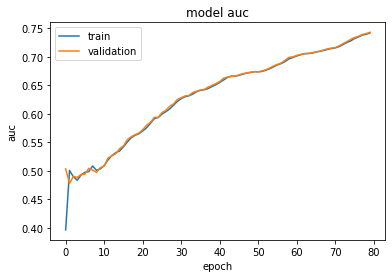

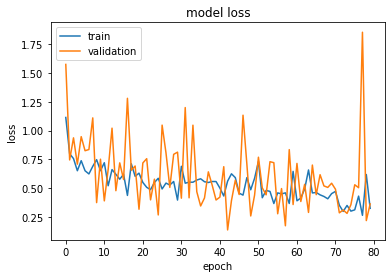

In [0]:
'''
Para evaluar como ha sido el desempeño del modelo realizamos un par de graficos
que nos muestran como se comporto la metrica AUC, tanto del conjunto de entrenamiento
como de validacion, durante las epocas en que se entreno el modelo.

Como segunda grafica observamos el comportamiento de la funcion de costo, al igual que el 
auc, para train y validacion durante todas las epocas
'''

# Grafica 1: Comportamiento desempeño AUC 
plt.plot(historia2.history['auc'])
plt.plot(historia2.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Grafica 2: Comportamiento funcion de perdida
plt.plot(historia2.history['loss'])
plt.plot(historia2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## 3. Red Neuronal Convolucional Pre-Entrenada (ResNet50)

In [0]:
''''
Estructuramos el DataAugmentacion que se va a utilizar durante el entrenamiento de las imagenes para esto se utiliza 
ImageDataGenerator como se menciono anteriormente, la cual se configuro de la siguiente manera:

--> rescale: Se utiliza para hacer una normalizacion de los datos de entrada, para esto se utilizo la forma que 
realiza el preprocesamiento de datos de resnet50: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
este rescale se utilizara tanto para los datos de train, como de validacion y test de todos los modelos.

--> horizontal_flip:  Ejecuta vueltas a las imagenes (efecto similar a un espejo)

--> rotation_range: Rotaciónn de la imagen en el rango [0,90]

--> brightness_range: Cambia los niveles de luminosidad de la imagen

--> : Realiza Zoom a la imagen (Si < 1 acerco, = 1 Misma imagen, > 1 Alejo)

''''

train_datagen = ImageDataGenerator(
    rescale=1. / 127.5 - 1,
    horizontal_flip=True,                                        
    rotation_range=90,                                           
    brightness_range=[0.2,0.8],                                  
    zoom_range=[0.8,1.2])                                        


'''
Ahora instanciamos lo que se utilizará como datos de entranmiento y le damos el directorio donde se encuentran
las imagenes, teniendo en cuenta el train.datagen anterior que será el encargado de realizar el data augmentation
'''
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,                                             
    target_size=(img_width, img_height),                            
    batch_size=batch_size,                                      
    shuffle = False,                                                               
    class_mode='binary')                                         


'''
Ahora instanciamos lo que se utilizará como datos de validación y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''
validation_datagen = ImageDataGenerator(rescale=1. / 127.5 - 1)
validation_generator = validation_datagen.flow_from_directory(  
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size, shuffle = False,
    class_mode='binary') 


'''
Ahora instanciamos lo que se utilizará como datos de test y le damos el directorio donde se encuentran
las imagenes. Para este caso no se realiza el data augmentation, este se emplea en entrenamiento.
'''
test_datagen = ImageDataGenerator(rescale= 1. / 127.5 - 1) 
test_generator = test_datagen.flow_from_directory(  
    test_data_dir,
    target_size=(img_width, img_height), 
    batch_size=2, shuffle = False,
    class_mode='binary') 

Found 50 images belonging to 2 classes.
Found 15 images belonging to 2 classes.
Found 17 images belonging to 2 classes.


In [0]:
'''
Importamos la red neuronal resnet50 desde keras sin incluir la capa de salida,
a continuacion añadimos la capa de salida propia que utilizara una funcion sigmoide
para el problema de clasificacion binaria. 
'''

import tensorflow as tf
K.clear_session()

# Instacia del modelo y configuración
base_model = tf.keras.applications.resnet50.ResNet50(weights= 'imagenet', 
                                            include_top=False,              
                                            input_shape= (400,400,3))

x = base_model.output                                               
x = tf.keras.layers.GlobalAveragePooling2D()(x)                     
x = tf.keras.layers.Dropout(0.5)(x)                                 

predictions = tf.keras.layers.Dense(1,                             
                    activation= 'sigmoid')(x)

'''
Unimos la capa de entrada que es resnet50 ( o sus pesos) con la capa de salida diseñada anteriormente
'''
model_3 = tf.keras.models.Model(inputs = base_model.input, 
                              outputs = predictions)


'''
Una vez construida construida la arquitectura de la red convolucional resnet50
debemos compilar el modelo, en este paso definimos que función de perdida vamos a utilizar, que optimizador 
y que metricas queremos medir. Para esta modelación se utilizói lo siguiente

--> Función de perdida (loss): binary_crossentropy: La función de pérdida de crossentropía binaria se usa en decisiones sí / no, 1 / 0, por ejemplo.
La pérdida le dice cuán equivocadas son las predicciones del modelo: https://www.tensorflow.org/api_docs/python/tf/keras/losses/binary_crossentropy

--> Optimizador: Adam con tasa de aprendizaje 0.0001: Adam es un método de descenso de gradiente estocástico que se basa en la estimación adaptativa de 
los momentos de primer y segundo orden: https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam

--> Metrica: AUC: (Área bajo la curva) el cual mide  el “área o espacio” bajo la curva ROC y tiene por objeto medir la certeza de un modelo a la 
hora de realizar predicciones (toma valor de 1 cuándo se es 100% preciso) siendo invariable al umbral de clasificación.
https://www.tensorflow.org/api_docs/python/tf/keras/metrics/AUC
'''

model_3.compile(loss='binary_crossentropy',                                      
                optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),         
                metrics=[tf.keras.metrics.AUC()])                                                             

# Observemos la arquitectura del modelo resnet50
model_3.summary()                                                 

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400, 400, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 406, 406, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 200, 200, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 200, 200, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [0]:
'''
Una vez tenemos lista la arquitectura y compilado el modelo procedemos a realiza el entrenamiento mediante el metodo fit_generator
en donde se le define cuales son los datos de entrada, el numero de epocas (# numero de veces que la red pasa por los datos) y cuales
son los datos de validacion
'''

historia3 = model_3.fit_generator(train_generator,                             
                                  epochs=50,                           
                                  validation_data=validation_generator,      
                                  verbose=1,
                                  workers=1,
                                  use_multiprocessing = False)


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
7/7 [==============================] - 5s 660ms/step - loss: 1.0132 - auc: 0.2861 - val_loss: 0.8208 - val_auc: 0.4432
Epoch 2/50
7/7 [==============================] - 3s 498ms/step - loss: 0.6398 - auc: 0.6480 - val_loss: 0.5708 - val_auc: 0.5909
Epoch 3/50
7/7 [==============================] - 3s 495ms/step - loss: 0.6306 - auc: 0.6337 - val_loss: 0.5009 - val_auc: 0.7727
Epoch 4/50
7/7 [==============================] - 3s 490ms/step - loss: 0.5479 - auc: 0.7371 - val_loss: 0.4546 - val_auc: 0.8636
Epoch 5/50
7/7 [==============================] - 3s 495ms/step - loss: 0.5017 - auc: 0.8209 - val_loss: 0.4035 - val_auc: 0.8864
Epoch 6/50
7/7 [==============================] - 3s 491ms/step - loss: 0.4558 - auc: 0.8663 - val_loss: 0.4295 - val_auc: 0.8864
Epoch 7/50
7/7 [==============================] - 3s 493ms/step - loss: 0.4589 - auc: 0.8663 - val_loss: 0.5644 - val_auc: 0.7955
Epoch 8/50
7/7

In [0]:
# Observamos el rendimiento con los datos de testeo
model_3.evaluate_generator(test_generator ) 

Instructions for updating:
Please use Model.evaluate, which supports generators.


[0.10437150299549103, 0.9999999403953552]

In [0]:
# Guardo el modelo
model_3.save("modelo_3_Resnet50_vf_80.h5")

### Graficas de desempeño

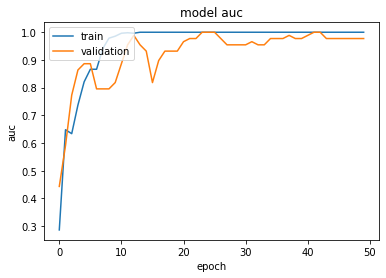

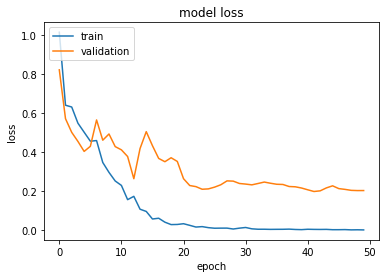

In [0]:
'''
Para evaluar como ha sido el desempeño del modelo realizamos un par de graficos
que nos muestran como se comporto la metrica AUC, tanto del conjunto de entrenamiento
como de validacion, durante las epocas en que se entreno el modelo.

Como segunda grafica observamos el comportamiento de la funcion de costo, al igual que el 
auc, para train y validacion durante todas las epocas
'''

# Grafica 1: Comportamiento desempeño AUC 
plt.plot(historia3.history['auc'])
plt.plot(historia3.history['val_auc'])
plt.title('model auc')
plt.ylabel('auc')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Grafica 2: Comportamiento funcion de perdida
plt.plot(historia3.history['loss'])
plt.plot(historia3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()